In [28]:
!pip install gdown==4.6.0 -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, f_classif

In [3]:
!gdown 168PiAwrnNMaWwjxk8kqUCjNoTZ6kpFgU

Downloading...
From: https://drive.google.com/uc?id=168PiAwrnNMaWwjxk8kqUCjNoTZ6kpFgU
To: /content/features_table.csv
100% 6.63M/6.63M [00:00<00:00, 54.1MB/s]


In [4]:
data = pd.read_csv('features_table.csv', encoding = 'utf-8')

In [5]:
def count_digits_in_column(df, column_name):
    # Calculate the number of digits in each row and create a new column
    df['digit_count'] = df[column_name].apply(lambda x: sum(c.isdigit() for c in x))
    return df

data = count_digits_in_column(data, 'review_text')

In [6]:
original_features = data.columns
print(original_features, len(original_features))

data.head(5)

Index(['ID', 'label', 'pos_neg', 'review_text', 'sentences', 'label_str',
       'text_length', 'num_sentences', 'flesch_readability_score',
       'content_word_count', 'function_word_count', 'verb_count', 'noun_count',
       'adjective_count', 'tokenized_text', 'filtered_text',
       'filtered_text_list', 'lemmatized_text', 'neg', 'neu', 'pos',
       'compound', 'punctuation_count', 'cap_count', 'ner_count',
       'digit_count'],
      dtype='object') 26


,ID,label,pos_neg,review_text,sentences,label_str,text_length,num_sentences,flesch_readability_score,content_word_count,...,filtered_text_list,lemmatized_text,neg,neu,pos,compound,punctuation_count,cap_count,ner_count,digit_count
0,sheraton_14,1,pos,The sheraton was a wonderful hotel! When me an...,7,Truthful,385,6,77.23,41,...,"['sheraton', 'wonderful', 'hotel', '!', 'mom',...",sheraton wonderful hotel ! mom flew really tir...,0.096,0.735,0.169,0.8217,7,7,1,0
1,talbott_13,0,pos,My husband and I decided to plan a romantic ge...,7,Deceptive,655,8,71.75,63,...,"['husband', 'decided', 'plan', 'romantic', 'ge...",husband decided plan romantic get-away one yea...,0.000,0.844,0.156,0.9565,11,18,5,0
2,sheraton_2,0,neg,The Sheraton Chicago Hotel and Towers is not t...,10,Deceptive,874,11,64.71,87,...,"['Sheraton', 'Chicago', 'Hotel', 'Towers', 'ho...",Sheraton Chicago Hotel Towers hotel person wis...,0.000,0.840,0.160,0.9694,11,14,2,0
3,palmer_10,1,neg,"First of all, Expedia.com charged me for an ad...",11,Truthful,992,9,71.65,97,...,"['First', ',', 'Expedia.com', 'charged', 'addi...","First , Expedia.com charged additional person ...",0.050,0.811,0.139,0.9760,18,18,8,2
4,james_17,1,pos,took a weekend trip with my wife. got a great ...,5,Truthful,290,6,86.30,35,...,"['took', 'weekend', 'trip', 'wife', '.', 'got'...",took weekend trip wife . got great rate valet ...,0.080,0.728,0.191,0.6757,9,0,2,0


In [9]:
train_df_70, test_df_30 = train_test_split(data, test_size=0.3, random_state=13, shuffle = True, stratify=data["label"])
print(train_df_70.columns)

#feature_columns = [col for col in train_df_70.columns if col not in ('ID', 'label', 'label_str', "filtered_text_list", "filtered_text", "tokenized_text", "pos_neg", "review_text", "content_function_pos_counts", "pos_counts",
#                                                                     "lemmatized_text", 'neg', 'neu', 'pos', "function_word_count", "filtered_text_joined",
#                                                                     "content_word_count")]

feature_columns = [col for col in train_df_70.columns if col not in ('ID', 'label', 'label_str', "filtered_text_list", "filtered_text", "tokenized_text", "pos_neg", "review_text", "content_function_pos_counts", "pos_counts",
                                                         "lemmatized_text", 'neg', 'neu', 'pos',  "filtered_text_joined",
                                                         #"content_word_count", "function_word_count", "cap_count"
                                                        "noun_count", "verb_count", "num_sentences", "function_word_count","adjective_count", "text_length")]


# Extracting the target variable 'label'
y_train = train_df_70['label']
y_test = test_df_30['label']
X_train = train_df_70[feature_columns]
X_test = test_df_30[feature_columns]
print(X_train.columns)

Index(['ID', 'label', 'pos_neg', 'review_text', 'sentences', 'label_str',
       'text_length', 'num_sentences', 'flesch_readability_score',
       'content_word_count', 'function_word_count', 'verb_count', 'noun_count',
       'adjective_count', 'tokenized_text', 'filtered_text',
       'filtered_text_list', 'lemmatized_text', 'neg', 'neu', 'pos',
       'compound', 'punctuation_count', 'cap_count', 'ner_count',
       'digit_count'],
      dtype='object')
Index(['sentences', 'flesch_readability_score', 'content_word_count',
       'compound', 'punctuation_count', 'cap_count', 'ner_count',
       'digit_count'],
      dtype='object')


In [10]:
print(X_train.shape)
print(X_test.shape)

(1120, 8)
(480, 8)


# Training a Baseline model: GBC with all features

In [11]:
gbc = GradientBoostingClassifier(max_depth= 5, random_state = 13)

# Train the model
gbc.fit(X_train, y_train)

# Make predictions
pred = gbc.predict(X_test)

# Calculate the F1 score
f1_score_all = round(f1_score(y_test,pred),3)

print(f1_score_all)

0.672


# Training a second Baseline model: LR with all features

In [12]:
# Create the classifier
lr = LogisticRegression(random_state=13)

# Train the model
lr.fit(X_train, y_train)

# Make predictions
pred = lr.predict(X_test)

# Calculate the F1 score
f1_score_all = round(f1_score(y_test, pred), 3)

print(f1_score_all)

0.686


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Variance threshold - Removing features with low variance

In [13]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [14]:
X_train_v1.var(axis = 0)

sentences                     29.214541
flesch_readability_score      90.869029
content_word_count          2203.557959
compound                       0.516150
punctuation_count            173.225864
cap_count                    178.079021
ner_count                     18.115409
digit_count                   16.464840
dtype: float64

In [15]:
#scaling to make the features comparable
scaler = MinMaxScaler()
scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

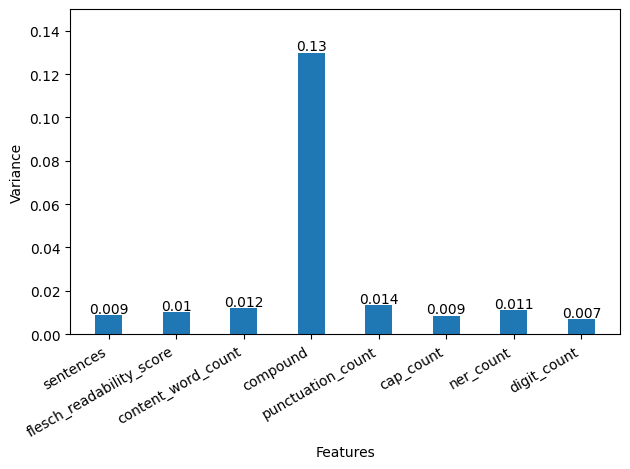

In [16]:
#plotting the variance of the features
fig, ax = plt.subplots()

x = X_train_v1.columns
y = scaled_X_train_v1.var(axis = 0)

ax.bar(x,y,width=0.4)
ax.set_xlabel("Features")
ax.set_ylabel("Variance")
ax.set_ylim(0, 0.15)

for index, value in enumerate(y):
  plt.text(x=index, y = value+ 0.001, s = str(round(value,3)), ha = "center")

fig.autofmt_xdate()
plt.tight_layout()

In [17]:
# Removing the feature with the lowest variance and measuring the performance
sel_X_train_v1 = X_train.drop(["cap_count"], axis = 1)
sel_X_test_v1 = X_test.drop(["cap_count"], axis = 1)

gbc.fit(sel_X_train_v1, y_train_v1)
var_preds = gbc.predict(sel_X_test_v1)

f1_score_var= round(f1_score(y_test_v1,var_preds),3)


print(f1_score_var)

0.653


# Mutual information - k-best features
calculate the most important feature and select the top 3 or 5 features

In [18]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [19]:
f1_score_list = []

for k in range(1, 9):
    # Increase max_iter for LogisticRegression
    lr = LogisticRegression(solver='lbfgs', max_iter=1000)  # Adjust max_iter as needed

    selector = SelectKBest(mutual_info_classif, k=k)
    selector.fit(X_train_v2, y_train_v2)

    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)

    lr.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = lr.predict(sel_X_test_v2)

    f1_score_kbest = round(f1_score(y_test_v2, kbest_preds), 3)
    f1_score_list.append(f1_score_kbest)


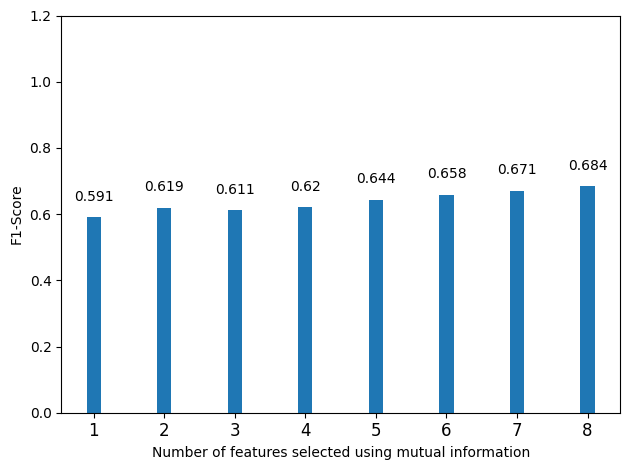

In [20]:
fig, ax = plt.subplots()

x = np.arange(1, 9)
y = f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using mutual information')
ax.set_ylabel('F1-Score')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 9))
ax.set_xticklabels(np.arange(1, 9), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()

In [ ]:
selector = SelectKBest(mutual_info_classif, k=5)
selector.fit(X_train_v2, y_train_v2)

selected_feature_mask = selector.get_support()

selected_features = X_train_v2.columns[selected_feature_mask]

selected_features

Index(['compound', 'punctuation_count', 'cap_count', 'ner_count',
       'digit_count'],
      dtype='object')

## Recursive feature elimination - wrapper method
- calculates the feature importance
- must use a model that has a way of calculating feature importance (tree like)

In [26]:
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [29]:
rfe_f1_score_list = []

for k in range(1, 9):
    RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train_v3, y_train_v3)

    sel_X_train_v3 = RFE_selector.transform(X_train_v3)
    sel_X_test_v3 = RFE_selector.transform(X_test_v3)

    gbc.fit(sel_X_train_v3, y_train_v3)
    RFE_preds = gbc.predict(sel_X_test_v3)

    f1_score_rfe = round(f1_score(y_test_v3, RFE_preds), 3)

    rfe_f1_score_list.append(f1_score_rfe)

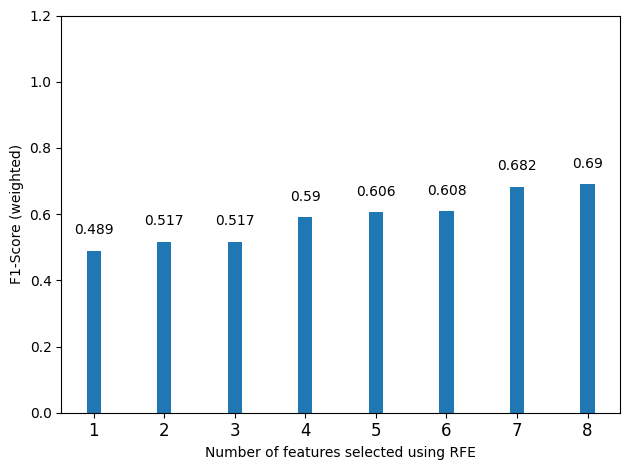

In [30]:
fig, ax = plt.subplots()

x = np.arange(1, 9)
y = rfe_f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using RFE')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, 9))
ax.set_xticklabels(np.arange(1, 9), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()

In [31]:
RFE_selector = RFE(estimator=gbc, n_features_to_select=8, step=10)
RFE_selector.fit(X_train_v3, y_train_v3)

selected_features_mask = RFE_selector.get_support()

selected_features = X_train_v3.columns[selected_features_mask]
selected_features

Index(['sentences', 'flesch_readability_score', 'content_word_count',
       'compound', 'punctuation_count', 'cap_count', 'ner_count',
       'digit_count'],
      dtype='object')

# Boruta

In [22]:
X_train_v4, X_test_v4, y_train_v4, y_test_v4 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [23]:
!pip install boruta -q

from boruta import BorutaPy

boruta_selector = BorutaPy(gbc, random_state=42)

boruta_selector.fit(X_train_v4.values, y_train_v4.values.ravel())

sel_X_train_v4 = boruta_selector.transform(X_train_v4.values)
sel_X_test_v4 = boruta_selector.transform(X_test_v4.values)

gbc.fit(sel_X_train_v4, y_train_v4)

boruta_preds = gbc.predict(sel_X_test_v4)

boruta_f1_score = round(f1_score(y_test_v4, boruta_preds, average='weighted'), 3)

In [24]:
selected_features_mask = boruta_selector.support_

selected_features = X_train_v4.columns[selected_features_mask]
selected_features

Index(['flesch_readability_score', 'compound', 'digit_count'], dtype='object')

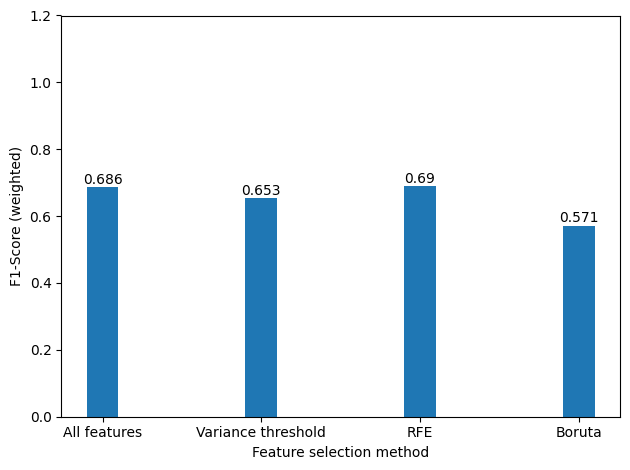

In [32]:
fig, ax = plt.subplots()

x = ['All features', 'Variance threshold', "RFE", 'Boruta']
y = [f1_score_all, f1_score_var, max(rfe_f1_score_list), boruta_f1_score]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)

for i, v in enumerate(y):
    plt.text(x=i, y=v+0.01, s=str(v), ha='center')

plt.tight_layout()